In [1]:
import numpy as np
import random
import math
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from gga import GGA
from island_ga import IslandGGA  
from chromosome import Chromosome 
import itertools

In [2]:
data=pd.read_csv('UA.csv')
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
#rename column to remove spaces in column names
data=pd.read_csv('UA.csv')
data =data.rename(columns={'Close': 'close', 'Volume': 'volume',
                           'Open':'open','High':'high','Low':'low'})
#change date string into date format and sort the dataframe in ascending order
data[['Date']] = data[['Date']].applymap(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
data =data.sort_values(by='Date')
#Create Signals using Talib library
data['5EMA'] = ta.SMA(np.array(data['close']),5)
data['20EMA'] = ta.EMA(np.array(data['close']), timeperiod = 20)
data['RSI'] = ta.RSI(np.array(data['close']), timeperiod = 14)
data['WILLR'] = ta.WILLR(np.array(data['high']), np.array(data['low']), np.array(data['close']), timeperiod=14)
data['MOM'] = ta.MOM(np.array(data['close']), timeperiod=5)
data['CCI'] = ta.CCI(np.array(data['high']), np.array(data['low']), np.array(data['close']), timeperiod=14)
data['SLOWK'],data['SLOWD'] = ta.STOCH(np.array(data['high']), np.array(data['low']), np.array(data['close']), fastk_period=14, slowk_period=3, slowd_period=3)
data['MACD'],data['MACDSIGNAL'],data['MACDHIST'] = ta.MACD(np.array(data['close']), fastperiod=12, slowperiod=26, signalperiod=9)
data['DMI'] = ta.DX(np.array(data['high']), np.array(data['low']), np.array(data['close']), timeperiod=14)   

In [4]:
#  """Based on parameter setting adopted in Chen et al (2021) """

def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1_CONDITIONS':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2_CONDITIONS':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3_CONDITIONS':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4_CONDITIONS':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6_CONDITIONS': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7_CONDITIONS': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8_CONDITIONS': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
data, strategies =generate_candidate_trading_signals(data.copy())

In [15]:
#split data
train = data[(data['Date'] <= date(2019,12,31))]
test = data[(data['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())
num_islands=5
num_iter=250
pSize=201
m_iter=10
N=15
K=3
r_cross=0.02
r_mut= 0.0001
r_inv=0.2
n=8
b=8
stop_loss=-0.15
take_profit=0.15
allocated_capital=1000
r_elite = 0.2
islandgga = IslandGGA(num_islands,num_iter,train_data,strategies,pSize,m_iter,N,K,r_cross,r_mut,r_inv,r_elite,n,b,stop_loss,take_profit,allocated_capital)

<AxesSubplot: >

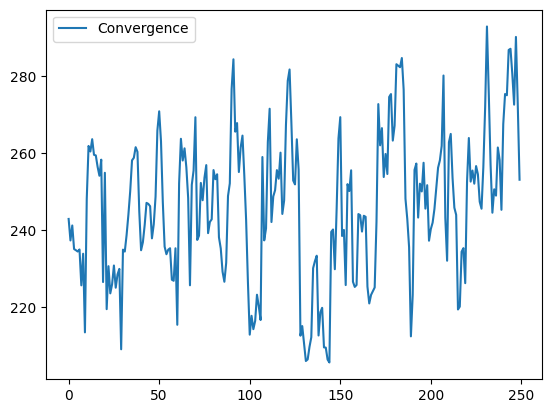

In [16]:
islandgga.evolve_island_ring()
cols = ["Convergence"]
df = pd.DataFrame(np.column_stack([islandgga.convergence_values]), columns=cols)
df.plot()

In [ ]:

p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    p_ring.append(getProfit(ring[i],test_data,allocated_capital))
    p_master.append(getProfit(master[i],test_data,allocated_capital))
    p_multi.append(getProfit(multi[i],test_data,allocated_capital))
    p_gga.append(getProfit(gga[i],test_data,allocated_capital))
cols = ["Ring Topology","Master-Slave","Multikuti",'GGA']
cols_1= ["Ring Topology","Master-Slave","Multikuti"]
df = pd.DataFrame(np.column_stack([p_ring,p_master,p_multi,p_gga]), 
                               columns=cols)


df.describe()

#df_1 =df_1.dropna(axis = 0)
#df.plot(kind='box')

In [ ]:
ring = []
master = []
multi = []
gga = []
for i in range(80):
    islandgga.evolve_island_ring()
    best  = islandgga.globalBest
    ring.append(best)
    islandgga.evolve_master_slave()
    best  = islandgga.globalBest
    master.append(best)
    islandgga.evolve_island_multikuti()
    best  = islandgga.globalBest
    multi.append(best)
    islandgga.evolve_gga()
    best  = islandgga.globalBest
    gga.append(best)
    print("ITERATION: {} DONE".format(i+1))
    print("========================")
p_ring = []
p_master = []
p_multi = []
p_gga = []
for i in range(80):
    p_ring.append(ring[i].getProfit(test_data,allocated_capital))
    p_master.append(master[i].getProfit(test_data,allocated_capital))
    p_multi.append(multi[i].getProfit(test_data,allocated_capital))
    p_gga.append(gga[i].getProfit(test_data,allocated_capital))
# multiple lines with legend
cols = ["Ring Topology","Master-Slave","Multikuti","GGA"]
df = pd.DataFrame({'Algorithm':cols, 'Total Return':[np.mean(p_ring),np.mean(p_master),np.mean(p_gga),np.mean(p_multi)]})
ax = df.plot.bar(x='Algorithm', y='Total Return', rot=0)

In [11]:
print(islandgga.globalBest)

SLTP: [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
GROUP: [['TS2_CONDITIONS', 'TS4_CONDITIONS', 'TS3_CONDITIONS'], ['TS5_CONDITIONS', 'TS8_CONDITIONS', 'TS1_CONDITIONS'], ['TS6_CONDITIONS', 'TS7_CONDITIONS']]
WEIGHT: [0, 0, 1, 1, 1, 1, 1]
FITNESS: 448.3334892005187
